In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

!pip install tslearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt

from keras.optimizers import Adagrad

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from tslearn.metrics import dtw_subsequence_path

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn import metrics

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

    100% |████████████████████████████████| 593kB 12.1MB/s ta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/c6/7d/46/0428fa5dc53f09a5f776ea1fef7a5c5abd79ce07393e9ef52d
Successfully built tslearn


Using TensorFlow backend.


['plasticc-clean-data', 'PLAsTiCC-2018']


In [2]:
dataset_folder = "../all"
!ls {dataset_folder}

target	train_ts  train_ts_err


In [3]:
test_metadata = pd.read_csv(f"../input/PLAsTiCC-2018/test_set_metadata.csv")
test_metadata.head(5)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023


In [4]:
def write_as_pickle(name, d):
    with open(name, 'wb') as f:
        pickle.dump(d, f, pickle.HIGHEST_PROTOCOL)
        
def read_pickle(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data

In [5]:
X_ts = read_pickle(f"{folder}/train_ts")
X_ts_err = read_pickle(f"{folder}/train_ts_err")
target = read_pickle(f"{folder}/target")
print(X_ts.shape)
print(X_ts_err.shape)
print(target.shape)

(7848, 1095, 6)
(7848, 1095, 6)
(7848,)


In [6]:
shapelets = read_pickle("../input/plasticc-clean-data/shapelets")
print(shapelets.shape)

(36,)


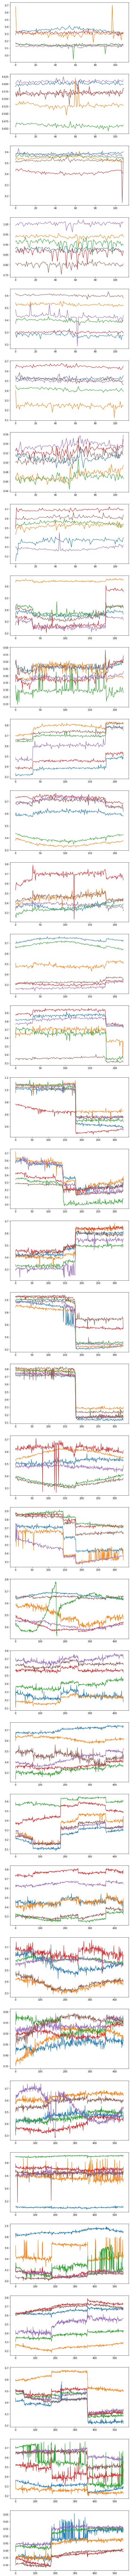

In [7]:
plt.figure(figsize=(9, 200))
for i, s in enumerate(shapelets):
    ax = plt.subplot(36, 1, i+1)
    ax.plot(s)

In [8]:
step = 1
nb_of_passband = X_ts.shape[2]
max_mjd = X_ts.shape[1] - 1
print(nb_of_passband, max_mjd, sep="\n")

6
1094


In [9]:
classes = np.unique(target)
classes = np.concatenate((classes, [99,]))
classes

array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95, 99])

In [10]:
targetToInt = {t: i for i, t in enumerate(classes)}
y = target.copy()
for j, t in enumerate(target):
    y[j] = targetToInt[t]

In [11]:
def normalize(ts, ts_err):
    ts /= (ts_err + 1) # +1 to avoid zero division
    ts = np.nan_to_num(ts)
    ts = TimeSeriesScalerMinMax().fit_transform(ts)
    return ts

In [12]:
X_ts_norm = normalize(X_ts, X_ts_err)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [13]:
def distanceToShapelet(ts, shapelet):
    path, dist = dtw_subsequence_path(shapelet, ts)
    return dist

In [14]:
def distanceToShapelets(ts, shapelets=shapelets):
    return [distanceToShapelet(ts, shapelet) for shapelet in shapelets]

In [15]:
X_dist = np.array([distanceToShapelets(ts_norm, shapelets) for ts_norm in X_ts_norm])
X_dist.shape

(7848, 36)

In [16]:
def get_best_classifier(model, X, y, verbose=0):
    cv_result = cross_validate(model, X, y, verbose=verbose, cv=4,return_estimator=True, scoring="neg_log_loss")
    best_index = np.argmax(cv_result["test_score"])
    print(f"Negative Log Loss: {-cv_result['test_score'][best_index]}")
    return cv_result["estimator"][best_index]

In [ ]:
xg_model = xgb.XGBClassifier(random_state=2, n_estimators=400)
xg_model = get_best_classifier(xg_model, X_dist, y, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


In [ ]:
write_as_pickle("xg_model", xg_model)

In [ ]:
write_as_pickle("xg_model", xg_model)

In [ ]:
target

In [ ]:
y

In [ ]:
def format_time_series(data):
    X = []
    X_err = []
    s0 = int(data.shape[0] / nb_of_passband)
    x, x_err = [], []
    for p in range(nb_of_passband):
        x = np.append(x, data[data.passband==p].flux.values)
        x_err = np.append(x_err, data[data.passband==p].flux_err.values)
    X.append(x.reshape(s0, nb_of_passband))
    X_err.append(x.reshape(s0, nb_of_passband))
    return np.array(X), np.array(X_err)

In [ ]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_ts.shape[0],
                                                       ts_sz=X_ts.shape[1],
                                                       n_classes=classes.shape[0],
                                                       l=0.1,
                                                       r=5)
shapelet_sizes

In [ ]:
def get_base_model():
    return ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=Adagrad(lr=.1),
                        weight_regularizer=.01,
                        batch_size=128,
                        max_iter=1,
                        verbose_level=1)

In [ ]:
def compute_score(y_true, y_pred):
    return metrics.log_loss(y_true=y_true, y_pred=y_pred)

In [ ]:
def get_best(X, y):
    skf = StratifiedKFold(n_splits=4)
    splits = skf.split(X, y)
    split = 0
    best_score = np.finfo(np.float64).max
    best_model = None
    splits = skf.split(X, y)
    model = get_base_model()
    for train_index, test_index in splits:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        score = compute_score(y_test, model.predict_proba(X_test))
        if score < best_score:
            best_score = score
            best_model = model
        print(f"Split-{split} score is:{score}")
        split += 1
        break
    print(f"BEST SCORE: {best_score}")
    return best_model

In [ ]:
# %%time
# shp_clf = get_best(X_ts_norm, y)

In [ ]:
# write_as_pickle("shapelets", shp_clf.shapelets_)

In [ ]:
def mjdToPredict(mjdToExclude, minMjd, maxMjd, step):
    return np.array(list(set(range(minMjd, maxMjd+1, step)) - set(mjdToExclude)))

In [ ]:
def fill_missing_flux(objectDf, maxMjd, step):
    objectDf.mjd = objectDf[["mjd"]].astype(np.int64)
    objectDf.mjd = objectDf.mjd - objectDf.mjd.min()
    instance = objectDf.groupby(["passband", "mjd"]).mean().reset_index()
    meanByPassband = instance.groupby("passband").mean()[["flux", "flux_err"]]
    frames = [instance]
    for p in range(6):
        toExclude = instance[instance.passband==p].mjd
        toPredict = mjdToPredict(toExclude, 0, maxMjd, step)
        nb = len(toPredict)
        frames.append(pd.DataFrame({
            'mjd': toPredict,
            'flux': [meanByPassband.loc[p].flux]*nb,
            'flux_err': [meanByPassband.loc[p].flux_err]*nb,
            'detected': [-1] * nb,
            'passband': [p]*nb,
            'object_id': [objectDf.object_id.values[0]]*nb
        }))
    return pd.concat(frames, sort=False)

In [ ]:
columns = ["object_id"]
columns.extend([f"class_{c}" for c in classes])
submission = pd.DataFrame(columns = columns)
submission

In [ ]:
def predict_batch(test_df):
    instance = fill_missing_flux(test_df, max_mjd, step)
    ts, ts_err = format_time_series(instance)
    ts_norm = normalize(ts, ts_err)
    dist_vec = distanceToShapelets(ts_norm[0], shapelets)
    preds = xg_model.predict_proba([dist_vec])[0]
    preds = np.concatenate(([test_df.object_id.values[0]], preds, [0]))
    submission.loc[submission.shape[0]] = preds

In [ ]:
max_nb_of_chunk = 10
start_at = 0
print("Starting at:", start_at)

In [ ]:
def predict_test_set(start_at=0):
    test_example = []
    curr_id = None
    i = 0
    for chunk in pd.read_csv("../input/PLAsTiCC-2018/test_set.csv", chunksize=1000, skiprows=list(range(1, start_at+1))):
        i += 1
        test_example.append(chunk.copy())
        if curr_id != None and chunk.object_id.values[-1] != curr_id:
    #         print("HERE 1")ts_norm
            tail = pd.concat(test_example)
            obj_ids = tail.object_id.unique()
            while obj_ids.shape[0] > 1:
                one_object_df = tail[tail.object_id==obj_ids[0]]
                predict_batch(one_object_df)
                obj_ids = np.delete(obj_ids, 0)
                start_at += one_object_df.shape[0]
            test_example = [tail[tail.object_id.isin(obj_ids)]]
            current_id = None if tail.shape[0] == 0 else tail.object_id.values[0]
        else:
            if curr_id is None:
                curr_id = chunk.object_id.values[0]
#     if i != max_nb_of_chunk:
#         print("EOF")
    test_df = pd.concat(test_example)
    predict_batch(test_df)
    print("End at:", start_at)

In [ ]:
%%time
predict_test_set(start_at=start_at)

In [ ]:
submission.object_id = submission.object_id.astype(np.int32, inplace=True)
submission.shape

In [ ]:
submission.to_csv("submission.csv", index=False)